In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from imblearn.over_sampling import SMOTE

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [2]:
X = []
y = []
maxx = -10000
minn = 10000

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('T88_111_MASKED_GFC.npz'):
            npzfile = np.load(os.path.join(dirname, filename))
            temp = npzfile['buffer']
            tmax, tmin = np.max(temp), np.min(temp)
            if tmax > maxx:
                maxx = tmax
            if tmin < minn:
                minn = tmin
            X.append(npzfile['buffer'])
            y.append(npzfile['label'])

In [3]:
print(maxx, minn)
X = (X - minn) / (maxx - minn)

3983.4158 -515.03125


In [4]:
len(X), len(y), X[0].shape, np.max(X), np.min(X)

(436, 436, (44, 52, 44, 1), 1.0, 0.0)

In [5]:
Y = []

for i in y:
    temp = None
    if i > 0:
        temp = 1
#         if i == 0.5:
#             temp = 1
#         else:
#             temp = 2
    else:
        temp = 0
    Y.append(temp)
# Y = tf.keras.utils.to_categorical(Y, 3)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=63, stratify = Y)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [7]:
len(x_train), x_train[0].shape, y_train.shape

(348, (44, 52, 44, 1), (348,))

In [8]:
sample_shape = [44, 52, 44, 1]
x_train = np.stack(x_train)
y_train = np.stack(y_train)

In [9]:
def getMultiscaleBlock(prev_layer, dilation_rate):
    aconv_1 = tf.keras.layers.Conv3D(32, kernel_size=(1, 1, 1), activation="relu", padding="SAME")(prev_layer)
    aconv_1 = tf.keras.layers.BatchNormalization()(aconv_1)
#     aconv_1 = tf.keras.layers.Dropout(0.5)(aconv_1)
    
    aconv_2 = tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation="relu", dilation_rate = dilation_rate, padding="SAME")(aconv_1)
    aconv_2 = tf.keras.layers.BatchNormalization()(aconv_2)
#     aconv_2 = tf.keras.layers.Dropout(0.5)(aconv_2)
    
    aconv_3 = tf.keras.layers.Conv3D(64, kernel_size=(1, 1, 1), activation="relu", padding="SAME")(aconv_2)
    aconv_3 = tf.keras.layers.BatchNormalization()(aconv_3)
#     aconv_3 = tf.keras.layers.Dropout(0.5)(aconv_3)
    
    return aconv_3

# Model 1 (MedNet Variant)
# with tpu_strategy.scope():
input_layer = tf.keras.Input(shape=sample_shape)

conv_1 = tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation="relu", padding="SAME")(input_layer)

aconv_1 = getMultiscaleBlock(conv_1, 1)
aconv_2 = getMultiscaleBlock(conv_1, 2)
aconv_3 = getMultiscaleBlock(conv_1, 4)

merge_1 = tf.keras.layers.concatenate([aconv_1, aconv_2, aconv_3])

conv_2 = tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), activation="relu", padding="SAME")(merge_1)
conv_2 = tf.keras.layers.BatchNormalization()(conv_2)
# conv_2 = tf.keras.layers.Dropout(0.5)(conv_2)
conv_2 = tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation="relu", padding="SAME")(conv_2)
conv_2 = tf.keras.layers.BatchNormalization()(conv_2)
conv_2 = tf.keras.layers.Dropout(0.5)(conv_2)
conv_2 = tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation="relu", padding="SAME")(conv_2)
conv_2 = tf.keras.layers.BatchNormalization()(conv_2)
# conv_2 = tf.keras.layers.Dropout(0.5)(conv_2)
conv_2 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2), padding="VALID")(conv_2)

conv_3 = tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), activation="relu", padding="SAME")(conv_2)
conv_3 = tf.keras.layers.BatchNormalization()(conv_3)
# conv_3 = tf.keras.layers.Dropout(0.5)(conv_3)
conv_3 = tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation="relu", padding="SAME")(conv_3)
conv_3 = tf.keras.layers.BatchNormalization()(conv_3)
conv_3 = tf.keras.layers.Dropout(0.5)(conv_3)
conv_3 = tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation="relu", padding="SAME")(conv_3)
conv_3 = tf.keras.layers.BatchNormalization()(conv_3)
# conv_3 = tf.keras.layers.Dropout(0.5)(conv_3)
conv_3 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2), padding="VALID")(conv_3)

conv_4 = tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation="relu", padding="SAME")(conv_3)
conv_4 = tf.keras.layers.BatchNormalization()(conv_4)

dConv_5 = tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation="relu", padding="SAME")(conv_4)
dConv_5 = tf.keras.layers.BatchNormalization()(dConv_5)
# dConv_5 = tf.keras.layers.Dropout(0.5)(dConv_5)
dConv_5 = tf.keras.layers.concatenate([dConv_5, conv_3])
dConv_5 = tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation="relu", padding="SAME")(dConv_5)

dConv_6 = tf.keras.layers.UpSampling3D(size=(2, 2, 2))(dConv_5)
dConv_6 = tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation="relu", padding="SAME")(dConv_6)
dConv_6 = tf.keras.layers.BatchNormalization()(dConv_6)
# dConv_6 = tf.keras.layers.Dropout(0.5)(dConv_6)
dConv_6 = tf.keras.layers.concatenate([dConv_6, conv_2])
dConv_6 = tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation="relu", padding="SAME")(dConv_6)

dConv_7 = tf.keras.layers.UpSampling3D(size=(2, 2, 2))(dConv_6)
dConv_7 = tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation="relu", padding="SAME")(dConv_7)
dConv_7 = tf.keras.layers.BatchNormalization()(dConv_7)
# dConv_7 = tf.keras.layers.Dropout(0.5)(dConv_7)
dConv_7 = tf.keras.layers.concatenate([dConv_7, merge_1])
dConv_7 = tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation="relu", padding="SAME")(dConv_7)

output = tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), activation="relu", padding="SAME")(dConv_7)
output = tf.keras.layers.Conv3D(16, kernel_size=(3, 3, 3), activation="relu", padding="SAME")(output)
# output = tf.keras.layers.Conv3D(1, kernel_size=(3, 3, 3), activation="relu", padding="SAME")(output)
output = layers.GlobalAveragePooling3D()(output)
output = layers.Dense(512, activation="relu")(output)
output = layers.Dropout(0.3)(output)
output = tf.keras.layers.Dense(64, activation="relu")(output)
output = layers.Dropout(0.3)(output)
output = tf.keras.layers.Dense(16, activation="relu")(output)
output = tf.keras.layers.Dense(3, activation="softmax")(output)
model = tf.keras.Model(inputs=input_layer, outputs=output)
initial_learning_rate = 0.0001 
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True) 
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), metrics=["acc"])

In [10]:
# Model 2 (MedNet Variant 2)
input_layer = tf.keras.Input(shape=sample_shape)

conv_1 = tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation="relu", padding="SAME")(input_layer)

aconv_1 = getMultiscaleBlock(conv_1, 1) 
aconv_2 = getMultiscaleBlock(conv_1, 2) 
aconv_3 = getMultiscaleBlock(conv_1, 4)

merge_1 = tf.keras.layers.concatenate([aconv_1, aconv_2, aconv_3])

conv_2 = tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), activation="relu", padding="SAME")(merge_1) 
conv_2 = tf.keras.layers.BatchNormalization()(conv_2)

# Define one hidden layer of Conv3D + Max Pooling
h1 = tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), activation="relu")(conv_2)
h1 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(h1)

# Define a second Conv3D layer with 64 units, 3x3x3 kernel, and relu activation
h2 = tf.keras.layers.Conv3D(64,kernel_size=(3, 3, 3), activation="relu")(h1)

# Define a second MaxPooling2D layer with 2x2 pool size
h2 = layers.GlobalAveragePooling3D()(h2) 

# Flatten the output from the last hidden layer so it can be passed to Dense layer
# h2 = tf.keras.layers.Flatten()(h2)

# Final output layer
output = tf.keras.layers.Dense(256, activation="relu")(h2)
output = tf.keras.layers.Dense(1, activation="sigmoid")(output)

# Build the model specifying the input and output layer
model = tf.keras.Model(inputs=input_layer, outputs=output)
initial_learning_rate = 0.0001 
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True) 
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), metrics=["acc"])

2022-12-05 22:22:42.221035: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 22:22:42.324016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 22:22:42.325275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 22:22:42.327369: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Model 3 (Keras Documentation Model for CT scan images)
def get_model(width=128, height=128, depth=64):

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

#     x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=3, activation="softmax")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model

model = get_model(width=44, height=52, depth=44)
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 44, 52, 44,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 44, 52, 44, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 44, 52, 44, 3 2080        conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_4 (Conv3D)               (None, 44, 52, 44, 3 2080        conv3d[0][0]                     
______________________________________________________________________________________________

In [12]:
sm = SMOTE(random_state=74)
x_train_reshaped = x_train.reshape(x_train.shape[0],-1)
x_smote, y_smote = sm.fit_resample(x_train_reshaped, y_train)
x_smote = x_smote.reshape(-1, x_train.shape[1], x_train.shape[2], x_train.shape[3])

In [13]:
x_smote.shape, y_smote.shape

((536, 44, 52, 44), (536,))

In [14]:
x_train_smote, x_val_smote, y_train_smote, y_val_smote = train_test_split(x_smote, y_smote, test_size = 0.2, random_state=73, stratify = y_smote)

In [15]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train_smote, y_train_smote))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val_smote, y_val_smote))

batch_size = 4
train_dataset = (
    train_loader.shuffle(len(x_train_smote))
    .batch(batch_size)
    .prefetch(4)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val_smote))
    .batch(batch_size)
    .prefetch(4)
)

In [16]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

In [17]:
epochs = 20
model_history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/20


2022-12-05 22:23:12.318464: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-05 22:23:13.520242: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


107/107 [==============================] - 46s 348ms/step - loss: 0.7018 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/20
107/107 [==============================] - 37s 345ms/step - loss: 0.6912 - acc: 0.5537 - val_loss: 0.6942 - val_acc: 0.5000
Epoch 3/20
107/107 [==============================] - 37s 345ms/step - loss: 0.6475 - acc: 0.6238 - val_loss: 0.6965 - val_acc: 0.5000
Epoch 4/20
107/107 [==============================] - 37s 345ms/step - loss: 0.5297 - acc: 0.7664 - val_loss: 0.6916 - val_acc: 0.5000
Epoch 5/20
107/107 [==============================] - 37s 345ms/step - loss: 0.5217 - acc: 0.7617 - val_loss: 0.6470 - val_acc: 0.6019
Epoch 6/20
107/107 [==============================] - 37s 345ms/step - loss: 0.4599 - acc: 0.7850 - val_loss: 0.5628 - val_acc: 0.8241
Epoch 7/20
107/107 [==============================] - 37s 345ms/step - loss: 0.4282 - acc: 0.8037 - val_loss: 0.6919 - val_acc: 0.6389
Epoch 8/20
107/107 [==============================] - 37s 345ms/st

In [19]:
x_test = np.stack(x_test)
y_test = np.stack(y_test)

In [20]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print("Test accuracy:", test_acc)
print("Test Loss:", test_loss)

Test accuracy: 0.7727272510528564
Test Loss: 1.239827275276184


In [21]:
y_pred = model.predict(x_test)

In [22]:
y_pred_new = []
y_test_new = []

for i in list(y_pred):
#     t = list(i)
#     k = t.index(max(t))
    k = 0 if i < 0.5 else 1
    y_pred_new.append(k)

for i in list(y_test):
#     t = list(i)
#     k = t.index(max(t))
    k = 0 if i < 0.5 else 1
    y_test_new.append(k)

In [23]:
print(classification_report(y_test_new, y_pred_new))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        68
           1       0.00      0.00      0.00        20

    accuracy                           0.77        88
   macro avg       0.39      0.50      0.44        88
weighted avg       0.60      0.77      0.67        88



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


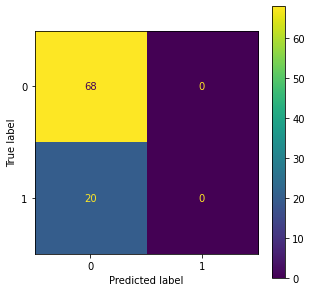

In [24]:
cm = confusion_matrix(y_test_new, y_pred_new)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)

In [25]:
# Checking SMOTE with Test Results
nsm = SMOTE(random_state=42)
x_test_reshaped = x_test.reshape(x_test.shape[0],-1)
x_test_smote, y_test_smote = nsm.fit_resample(x_test_reshaped, y_test)
x_test_smote = x_test_smote.reshape(-1, x_test.shape[1], x_test.shape[2], x_test.shape[3])

In [26]:
x_test_smote.shape, y_test_smote.shape

((136, 44, 52, 44), (136,))

In [27]:
y_pred_smote = model.predict(x_test_smote)

y_pred_dash = []
y_test_dash = []

for i in list(y_pred_smote):
#     t = list(i)
#     k = t.index(max(t))
    k = 0 if i < 0.5 else 1
    y_pred_dash.append(k)

for i in list(y_test_smote):
#     t = list(i)
#     k = t.index(max(t))
    k = 0 if i < 0.5 else 1
    y_test_dash.append(k)

In [28]:
print(classification_report(y_test_dash, y_pred_dash))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        68
           1       0.00      0.00      0.00        68

    accuracy                           0.50       136
   macro avg       0.25      0.50      0.33       136
weighted avg       0.25      0.50      0.33       136



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


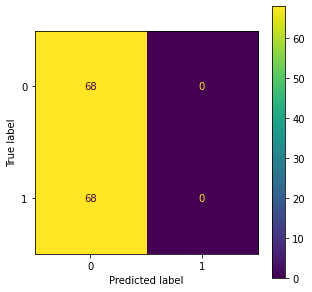

In [29]:
cm = confusion_matrix(y_test_dash, y_pred_dash)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)

In [30]:
history = model_history.history

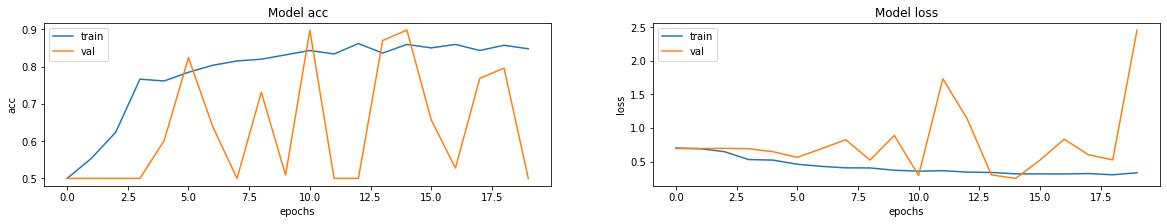

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(history[metric])
    ax[i].plot(history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])


In [32]:
model.load_weights("3d_image_classification.h5")

In [33]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print("Test accuracy:", test_acc)
print("Test Loss:", test_loss)

Test accuracy: 0.7954545617103577
Test Loss: 0.41279563307762146


In [34]:
y_pred = model.predict(x_test)

In [35]:
y_pred_new = []
y_test_new = []

for i in list(y_pred):
#     t = list(i)
#     k = t.index(max(t))
    k = 0 if i < 0.5 else 1
    y_pred_new.append(k)

for i in list(y_test):
#     t = list(i)
#     k = t.index(max(t))
    k = 0 if i < 0.5 else 1
    y_test_new.append(k)

In [36]:
print(classification_report(y_test_new, y_pred_new))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85        68
           1       0.53      0.95      0.68        20

    accuracy                           0.80        88
   macro avg       0.75      0.85      0.76        88
weighted avg       0.88      0.80      0.81        88



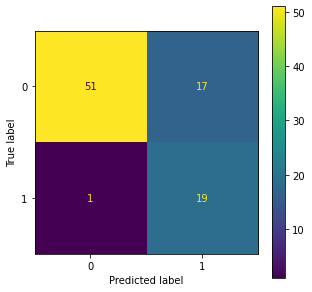

In [37]:
cm = confusion_matrix(y_test_new, y_pred_new)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)

In [38]:
model.load_weights('/kaggle/input/ad-saved-model-1/3d_image_classification.h5') 

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/kaggle/input/ad-saved-model-1/3d_image_classification.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [39]:
test_loss, test_acc = model.evaluate(x_test_smote, y_test_smote, verbose=0)

print("Test accuracy:", test_acc)
print("Test Loss:", test_loss)

Test accuracy: 0.8676470518112183
Test Loss: 0.30253973603248596


In [40]:
y_pred = model.predict(x_test_smote)

In [41]:
y_pred_new = []
y_test_new = []

for i in list(y_pred):
#     t = list(i)
#     k = t.index(max(t))
    k = 0 if i < 0.5 else 1
    y_pred_new.append(k)

for i in list(y_test_smote):
#     t = list(i)
#     k = t.index(max(t))
    k = 0 if i < 0.5 else 1
    y_test_new.append(k)

In [42]:
print(classification_report(y_test_new, y_pred_new))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85        68
           1       0.80      0.99      0.88        68

    accuracy                           0.87       136
   macro avg       0.89      0.87      0.87       136
weighted avg       0.89      0.87      0.87       136



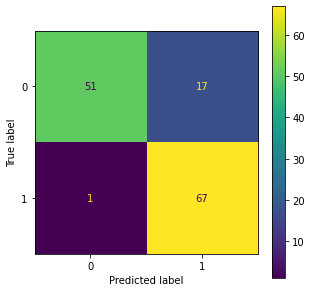

In [43]:
cm = confusion_matrix(y_test_new, y_pred_new)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)